In [3]:
import os
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import seaborn as sns
import umap
import matplotlib.pyplot as plt

In [5]:
wb_gene_ontology_data = "/home/dan/Code/Notebooks/umass_med_notebooks/unknown_genes/input_data/wormbase_db/wb_gene_ontology_data.csv"
wb_gene_ontology_df = pd.read_csv(wb_gene_ontology_data)
wb_gene_ontology_df.head()

,wormbase_id,go_id,go_category,go_term
0,WBGene00010728,GO:0016020,Cellular_component,membrane
1,WBGene00010730,GO:0004864,Molecular_function,protein phosphatase inhibitor activity
2,WBGene00010730,GO:0005737,Cellular_component,cytoplasm
3,WBGene00010730,GO:0035308,Biological_process,negative regulation of protein dephosphorylation
4,WBGene00010730,GO:0007049,Biological_process,cell cycle


In [7]:
go_counts = wb_gene_ontology_df['go_id'].value_counts()
go_mf_counts = wb_gene_ontology_df[wb_gene_ontology_df['go_category'] == 'Molecular_function']['go_id'].value_counts()
go_cc_counts = wb_gene_ontology_df[wb_gene_ontology_df['go_category'] == 'Cellular_component']['go_id'].value_counts()
go_bp_counts = wb_gene_ontology_df[wb_gene_ontology_df['go_category'] == 'Biological_process']['go_id'].value_counts()

print(f"Molecular_function {len(go_mf_counts):>5,}")
print(f"Cellular_component {len(go_cc_counts):>5,}")
print(f"Biological_process {len(go_bp_counts):>5,}")
print("="*25)
print(f"All                {len(go_counts):>5,}")


Molecular_function 2,246
Cellular_component   947
Biological_process 3,697
All                6,890


In [9]:
def one_hot_encode_ontology_data(ontology_data_full_df, genes_to_encode_df, go_category):
    #Create empty go terms dict
    unique_go_ids = ontology_data_full_df['go_id'].unique()
    empty_go_terms_dict = {go_term: 0 for go_term in unique_go_ids}

    genes_to_encode_ids = genes_to_encode_df['wormbase_id'].unique()

    one_hot_encoded_lst = []
    counter=0
    number_of_rows = len(genes_to_encode_ids)
    for wormbase_id in genes_to_encode_ids:
        print(".", end='')
        counter +=1
        go_terms_dict = empty_go_terms_dict.copy()
        go_terms_for_wb_id_df = ontology_data_full_df[(ontology_data_full_df['wormbase_id'] == wormbase_id) & (ontology_data_full_df['go_category'] == go_category)]
        for index, go_terms_for_wb_id_row in go_terms_for_wb_id_df.iterrows():
            go_terms_dict[go_terms_for_wb_id_row['go_id']]=1

        one_hot_list=list(go_terms_dict.values())
        row = [wormbase_id] + one_hot_list    
        one_hot_encoded_lst.append(row)

        # Show progress
        if counter % 100 == 0:
            print(f"{counter:>4} of {number_of_rows:>6,} {wormbase_id}")

    print(f"{counter:>4} of {number_of_rows:>6,}")

    one_hot_encoded_df = pd.DataFrame(one_hot_encoded_lst, columns=['wormbase_id']+list(go_terms_dict.keys()))
    return one_hot_encoded_df



In [42]:

def create_umap(one_hot_encoded_df):
    # Select only the GO annotations for clustering
    wormbase_id_series = one_hot_encoded_df['wormbase_id']
    X = one_hot_encoded_df.drop('wormbase_id', axis=1)
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply UMAP to reduce the data to 2 dimensions
    umap_model = umap.UMAP(n_components=2)
    X_umap = umap_model.fit_transform(X_scaled)
    X_umap_df = pd.DataFrame(X_umap, columns = ['X','Y'])
    X_umap_df['wormbase_id'] = wormbase_id_series
    print(X_umap_df.head())
    return X_umap_df

def plot_umap(X_umap_df, category, subplot_index):
    # Plot the UMAP visualization
    #plt.figure(figsize=(10, 6))
    colors = {0:'#4eb3d3',1:'#298dbe',2:'#97509f',3:'#e41e26',4:'#f16b4e',
          5:'#f47f20',6:'#a65728','7':'#4bb049','8':'#f5ee39','9':'#cde7c4',
          '10':'#b2cee4','11':'#decbe3','12':'#cde9e4','13':'#7f7f7f','14':'#860084'}

    plt.subplot(2, 2, subplot_index)
    print(X_umap_df.head())
    plt.scatter(X_umap_df['X'], X_umap_df['Y'],  c= X_umap_df['cluster_id'].map(colors), s=20, alpha=0.5)
    #plt.scatter(X_umap[:, 0], X_umap[:, 1], cmap='viridis', s=20, alpha=0.5)
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.title(f"UMAP Visualization of Genes Based on {category} GO Annotations", fontweight='bold', fontsize=12, pad=10)
    plt.yticks([])
    plt.xticks([])
    
def define_clusters(X_umap_df,num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    # Fit the model to the data
    kmeans.fit(X_umap_df[['X', 'Y']])
    # Get the cluster labels
    cluster_labels = kmeans.labels_
    # Assign the cluster labels back to the DataFrame
    X_umap_df['cluster_id'] = cluster_labels
    return X_umap_df



In [43]:
analysis1_up_df = pd.read_csv("input_data/analysis1_up-with-correction.csv")
analysis1_up_df.rename(columns={'ID': 'wormbase_id'}, inplace=True)
analysis1_up_df.head()

,wormbase_id,T_CON_N2_Y,T_CON_N2_x,T_Con_N2_set2,T_Con_N2_set1,T_PQ_N2_set1,T_PQ_N2_Y,T_PQ_N2_x,T_PQ_N2_set2,padj,log2FoldChange,pvalue,stat,foldChange,log10padj
0,WBGene00000007,31.505361,38.468048,31.721094,63.158598,98.671683,118.928277,97.847573,85.912516,2.484573e-06,1.283663,5.477286e-07,25.087993,2.434564,5.604748
1,WBGene00000033,7.876340,8.877242,0.000000,0.986853,28.191909,15.990357,13.978225,36.962361,3.930530e-03,2.421857,1.783986e-03,9.759498,5.358603,2.405549
2,WBGene00000037,37.412616,35.508968,18.834400,9.868531,88.603144,54.966851,54.914454,93.904378,4.564855e-04,1.524373,1.639469e-04,14.204856,2.876616,3.340573
3,WBGene00000040,2024.219451,1734.021248,2392.960030,2568.778613,4839.946747,4975.999068,5389.604055,3885.043884,6.335757e-16,1.130472,2.598368e-17,71.628048,2.189304,15.198201
4,WBGene00000051,7.876340,9.863602,11.895410,9.868531,56.383819,55.966248,50.920676,46.952189,6.252963e-15,2.412148,2.892321e-16,66.875328,5.322663,14.203914


Encoding Cellular_component


/home/dan/miniconda3/envs/dan-dev-sc/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


            X          Y     wormbase_id
0  -10.276588   6.554010  WBGene00000007
1   -0.529546   0.676718  WBGene00000033
2   -6.863774  -2.989650  WBGene00000037
3  101.366684 -22.870802  WBGene00000040
4   97.650558 -22.028263  WBGene00000051
            X          Y     wormbase_id  cluster_id
0  -10.276588   6.554010  WBGene00000007           4
1   -0.529546   0.676718  WBGene00000033           0
2   -6.863774  -2.989650  WBGene00000037           2
3  101.366684 -22.870802  WBGene00000040           1
4   97.650558 -22.028263  WBGene00000051           1
Encoding Biological_process


/home/dan/miniconda3/envs/dan-dev-sc/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/dan/miniconda3/envs/dan-dev-sc/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


           X          Y     wormbase_id
0  -9.486100 -10.022532  WBGene00000007
1   5.509389  -7.470307  WBGene00000033
2  -7.985703 -14.311277  WBGene00000037
3  99.516930 -38.233189  WBGene00000040
4  96.162773 -36.371689  WBGene00000051
           X          Y     wormbase_id  cluster_id
0  -9.486100 -10.022532  WBGene00000007           2
1   5.509389  -7.470307  WBGene00000033           2
2  -7.985703 -14.311277  WBGene00000037           2
3  99.516930 -38.233189  WBGene00000040           1
4  96.162773 -36.371689  WBGene00000051           1
Encoding Molecular_function


/home/dan/miniconda3/envs/dan-dev-sc/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/dan/miniconda3/envs/dan-dev-sc/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


           X          Y     wormbase_id
0  -0.120010 -12.838950  WBGene00000007
1   8.100620  -3.554512  WBGene00000033
2   8.027910 -12.972935  WBGene00000037
3  57.018875  80.614243  WBGene00000040
4  52.942600  80.848145  WBGene00000051
           X          Y     wormbase_id  cluster_id
0  -0.120010 -12.838950  WBGene00000007           0
1   8.100620  -3.554512  WBGene00000033           3
2   8.027910 -12.972935  WBGene00000037           0
3  57.018875  80.614243  WBGene00000040           1
4  52.942600  80.848145  WBGene00000051           1


/home/dan/miniconda3/envs/dan-dev-sc/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


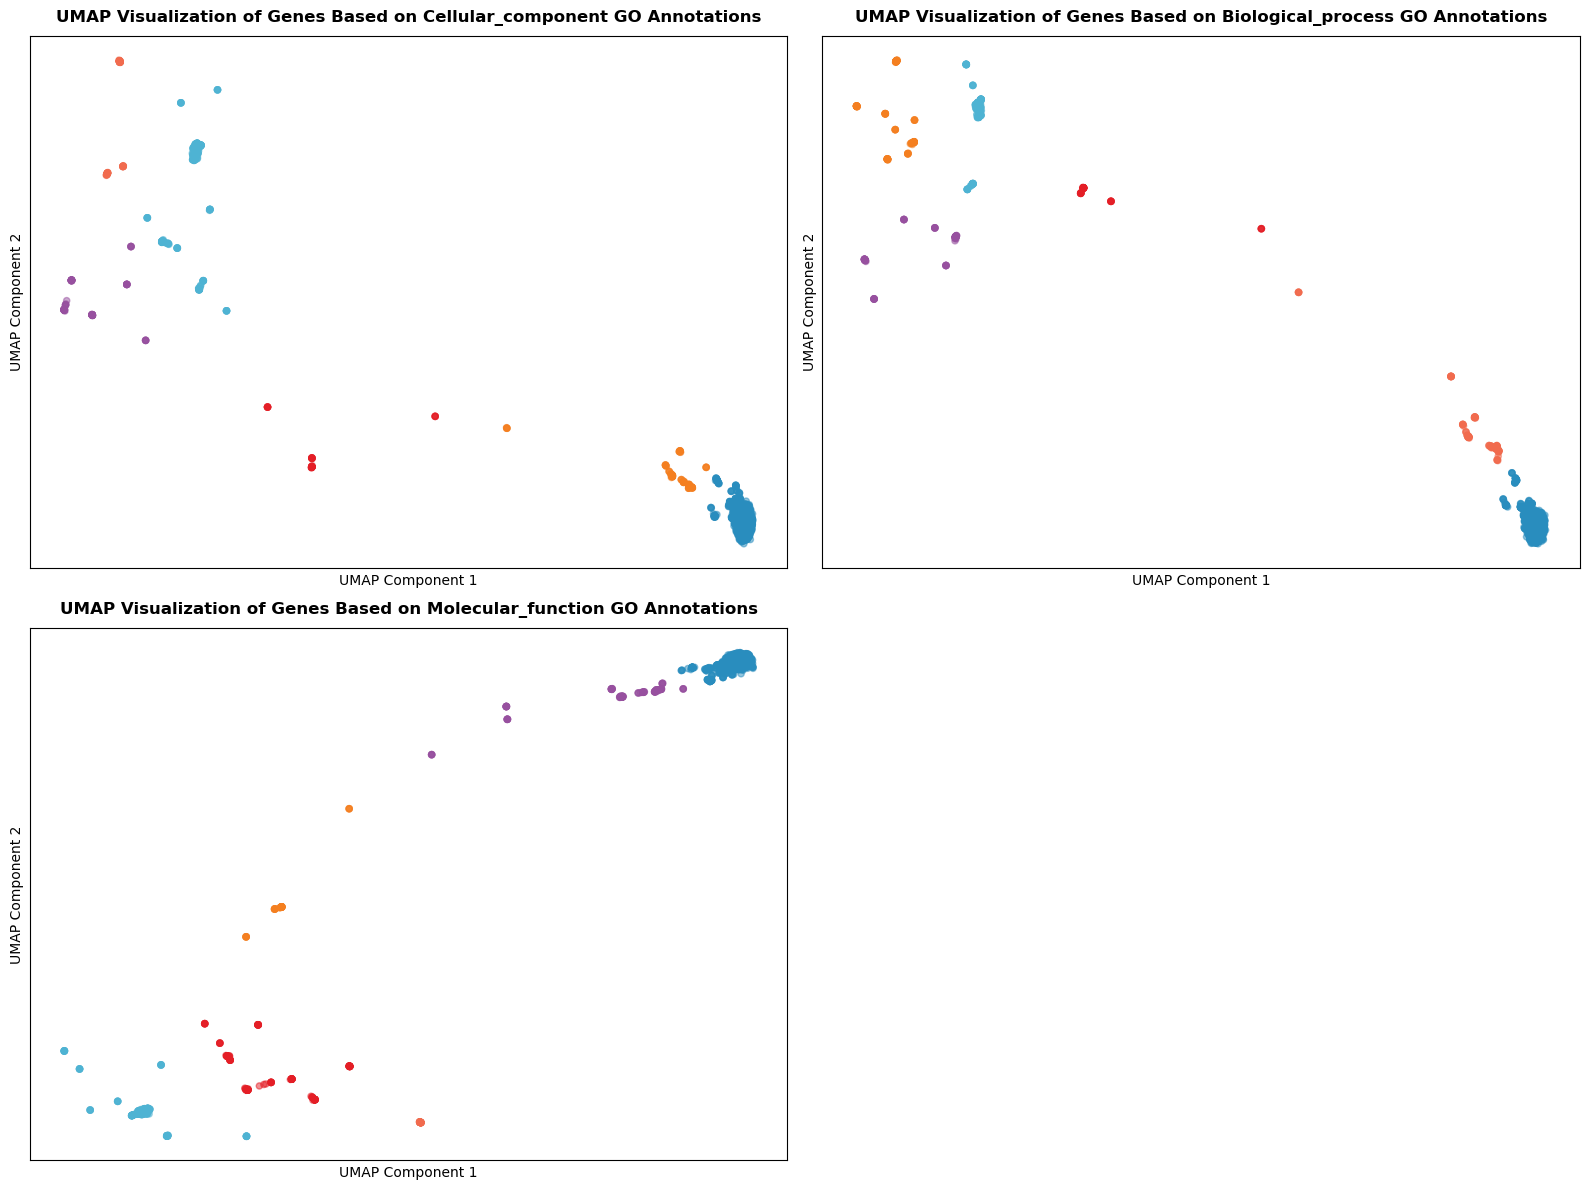

In [44]:
go_categories= ["Cellular_component","Biological_process", "Molecular_function"]

genes_to_encode_df = analysis1_up_df
num_clusters = 6

plt.figure(figsize=(16, 12))
for index, go_category in enumerate(go_categories):
    print(f"Encoding {go_category}")
    #one_hot_encoded_df = one_hot_encode_ontology_data(wb_gene_ontology_df, genes_to_encode_df, go_category)
    X_umap_df = create_umap(one_hot_encoded_df)
    X_umap_df = define_clusters(X_umap_df, num_clusters)
    plot_umap(X_umap_df, go_category, index+1)


plt.tight_layout()
plt.show()

1814


/home/dan/miniconda3/envs/dan-dev-sc/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


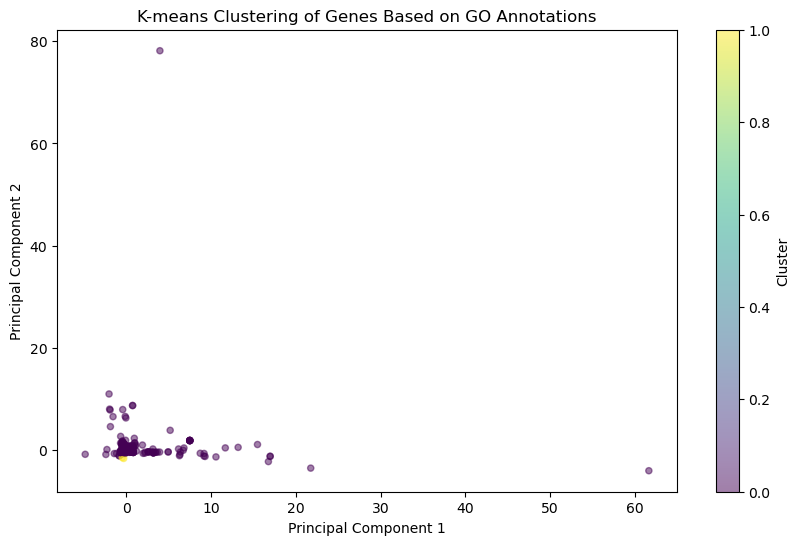

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
%matplotlib inline

output_dir = './output_data'
def plot_timepoint(X_umap_df, timepoint):
    # Create a color map
    colors = {'NA':'#7f7f7f','d1':'#4eb3d3','d3':'#f5ee39','d5':'#f47f20','d8':'#97509f','d11':'#e41e26','d15':'#4bb049'}
    plt.rcParams['figure.dpi'] = 500
    sss = plt.scatter(X_umap_df['X'], X_umap_df['Y'], c=X_umap_df[timepoint].map(colors), s=.008)
    plt.gca().set_aspect('equal', 'datalim')

    day = timepoint[1:] if timepoint[0]=='d' else 0
    plt.title(f'UMAP projection of cells by day {day}', fontsize=18);
    plt.yticks([])
    plt.xticks([])

    patches = [ mpatches.Patch(color=colors[key], label=key) for key in colors.keys()]
    plt.rcParams["legend.fontsize"] = 5
    legend = plt.legend(handles=patches)
    legend.set_title('Day')

    plt.savefig(f'{output_dir}/day_{int(day):02}.png')

timepoints = ['NA','d1','d3','d5','d8','d11','d15']
for timepoint in timepoints: 
    plot_timepoint(X_umap_df, timepoint)


              X          Y     wormbase_id  cluster_id
0     -4.209569 -10.448040  WBGene00000007           6
1     -0.827567   9.190826  WBGene00000033           1
2     -5.870569  -2.222326  WBGene00000037           6
3    -52.563675  85.763618  WBGene00000040           0
4    -48.532993  85.824142  WBGene00000051           5
...         ...        ...             ...         ...
1806 -53.473164  87.966118  WBGene00304792           0
1807 -53.977482  87.946671  WBGene00305067           0
1808 -53.814266  87.868263  WBGene00305992           0
1809 -53.798164  87.966797  WBGene00306002           0
1810 -53.618347  88.004814  WBGene00306003           0

[1811 rows x 4 columns]


/home/dan/miniconda3/envs/dan-dev-sc/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
